In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set()
%matplotlib inline

# Chapter 2: Multi-Armed Bandits

In this chapter, all material are related to the K-bandits testbed

In [2]:
class KArmedTestbed:
    def __init__(self, k, mean=0.0, std=1.0, step_std=0.0):
        self.q_star = np.random.normal(loc=mean, scale=std, size=k)
        self.step_std = step_std
  
    def __getitem__(self, i):
        self.q_star += np.random.normal(
            loc=0.0, scale=self.step_std, size=self.q_star.shape)
        return np.random.normal(loc=self.q_star[i], scale=1.0)
    
    def visualize(self, ax=None):
        x = np.tile(np.arange(self.q_star.shape[0]), (100, 1)).T
        y = np.random.normal(loc=self.q_star, scale=1.0, size=(100, 10)).T
        sns.violinplot(x=x.flatten(), y=y.flatten(), ax=ax)


class KArmedAgent:
    def __init__(self, k):
        self.q = np.zeros((k,))
        self.action = -1
        self.steps = np.zeros((k,))
    
    def observe(self, reward): return NotImplementedError()
    def take_action(self): return NotImplementedError()

## Excercise 2.5

In [3]:
class EpsilonGreedy(KArmedAgent):
    def __init__(self, k, epsilon=0.0, alpha=None):
        super().__init__(k)
        self.epsilon = epsilon
        self.alpha = alpha
    
    def observe(self, reward):
        if self.alpha is None:
            d = 1. / self.steps[self.action]
        else:
            d = self.alpha
        q_prev = self.q[self.action]
        q_next = q_prev + (reward - q_prev) * d
        self.q[self.action] = q_next
    
    def take_action(self):
        if np.random.uniform() < self.epsilon:
            self.action = np.random.choice(self.q.shape[0])
        else:
            self.action = np.argmax(self.q)
        self.steps[self.action] += 1
        return self.action

    
def test_agent(testbed, agent, steps=1000):
    ground_truth, actions, rewards = \
            np.zeros((steps,), dtype=np.int), \
            np.zeros((steps,), dtype=np.int), \
            np.zeros((steps,))
    for step in range(steps):
        ground_truth[step] = np.argmax(testbed.q_star)
        actions[step] = agent.take_action()
        rewards[step] = testbed[actions[step]]
        agent.observe(rewards[step])
    return ground_truth, actions, rewards

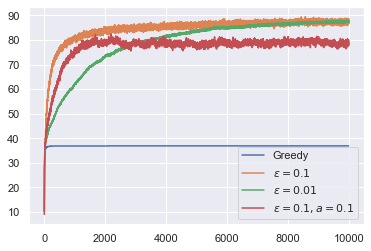

In [4]:
num_tests = 2000
num_steps = 10000

y1, y2, y3, y4 = (
    np.zeros((num_steps,)), np.zeros((num_steps,)),
    np.zeros((num_steps,)), np.zeros((num_steps,)))
for test in tqdm(range(num_tests)):
    agent_a = EpsilonGreedy(10)
    agent_b = EpsilonGreedy(10, epsilon=0.1)
    agent_c = EpsilonGreedy(10, epsilon=0.01)
    agent_d = EpsilonGreedy(10, epsilon=0.1, alpha=0.1)
    
    gt1, a1, _ = test_agent(KArmedTestbed(10), agent_a, steps=num_steps)
    gt2, a2, _ = test_agent(KArmedTestbed(10), agent_b, steps=num_steps)
    gt3, a3, _ = test_agent(KArmedTestbed(10), agent_c, steps=num_steps)
    gt4, a4, _ = test_agent(KArmedTestbed(10), agent_d, steps=num_steps)
    
    y1[gt1 == a1] += 1
    y2[gt2 == a2] += 1
    y3[gt3 == a3] += 1
    y4[gt4 == a4] += 1

y1 = 100. * y1 / num_tests
y2 = 100. * y2 / num_tests
y3 = 100. * y3 / num_tests
y4 = 100. * y4 / num_tests

sns.lineplot(np.arange(num_steps), y1, label='Greedy')
sns.lineplot(np.arange(num_steps), y2, label='$\epsilon = 0.1$')
sns.lineplot(np.arange(num_steps), y3, label='$\epsilon = 0.01$')
sns.lineplot(np.arange(num_steps), y4, label='$\epsilon = 0.1, a = 0.1$')

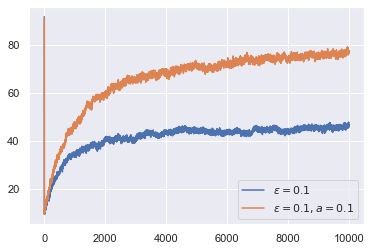

In [5]:
num_tests = 2000
num_steps = 10000

y1, y2 = np.zeros((num_steps,)), np.zeros((num_steps,))
for test in tqdm(range(num_tests)):    
    agent_a = EpsilonGreedy(10, epsilon=0.1)
    agent_b = EpsilonGreedy(10, epsilon=0.1, alpha=0.1)
    
    
    gt1, a1, _ = test_agent(KArmedTestbed(10, std=0.0, step_std=0.01), agent_a, steps=num_steps)
    gt2, a2, _ = test_agent(KArmedTestbed(10, std=0.0, step_std=0.01), agent_b, steps=num_steps)
    
    y1[gt1 == a1] += 1
    y2[gt2 == a2] += 1

y1 = 100. * y1 / num_tests
y2 = 100. * y2 / num_tests

sns.lineplot(np.arange(num_steps), y1, label='$\epsilon = 0.1$')
sns.lineplot(np.arange(num_steps), y2, label='$\epsilon = 0.1, a = 0.1$')